“This script demonstrates the following steps: 1. Load the ImageNet dataset using TensorFlow Datasets (TFDS). 2. Save images locally as JPEG files. 3. Reload the saved images and use them to create a dataset for training. 4. Define a simple CNN model using Flax. 5. Train the model on the dataset.”

In [48]:
import os
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from flax.training import train_state
import optax

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

%cd /hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
%ls

# Directory to save images
data_dir = '/hildafs/projects/phy230056p/junzhez/data/'
# data_name = 'imagenet2012_tfds'
data_name = 'mnist'
save_dir = os.path.join(data_dir, data_name)
os.makedirs(save_dir, exist_ok=True)

/hildafs/projects/phy230056p/junzhez/AI/maskgit/gmmg
config/       nets.ipynb  test1.ipynb        train_token.ipynb
layers.ipynb  src/        tf_datasets.ipynb


In [58]:
# Load ImageNet dataset
dataset_name = 'mnist'
split = 'train[:80%]'  # Using a small subset for demonstration purposes
dataset, info = tfds.load(dataset_name, data_dir=save_dir, split=split, with_info=True)

# Preprocess dataset
def preprocess(sample):
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.0
    label = sample['label']
    return image, label

dataset = dataset.map(preprocess)

# Convert to numpy arrays and batch the data
batch_size = 32
dataset = dataset.batch(batch_size)

In [59]:
# Define the model
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

# Initialize the model and optimizer
def create_train_state(rng, learning_rate):
    cnn = CNN()
    # batch_size, height, width, channels
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(learning_rate)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, batch['image'])
        one_hot = jax.nn.one_hot(batch['label'], 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

# Train the model
rng = jax.random.PRNGKey(0)
state = create_train_state(rng, learning_rate=0.01)

for epoch in range(10):  # Train for 10 epochs
    for batch in dataset.as_numpy_iterator():
        images, labels = batch
        batch = {'image': images, 'label': labels}
        state = train_step(state, batch)
    print(f'Epoch {epoch+1} completed')

print("Training completed!")

2024-05-29 00:49:58.234772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 completed


2024-05-29 00:49:58.825803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 completed


2024-05-29 00:49:59.398702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 completed


2024-05-29 00:50:00.050146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 completed


2024-05-29 00:50:00.644332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 completed


2024-05-29 00:50:01.244848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 completed


2024-05-29 00:50:01.818696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 completed


2024-05-29 00:50:02.391407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 completed


2024-05-29 00:50:02.993996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 completed
Epoch 10 completed
Training completed!


2024-05-29 00:50:03.627403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Evaluate and Visualize

We now also add in train and validation sets

In [60]:
# Load MNIST dataset using TensorFlow Datasets
dataset_name = 'mnist'
train_split = 'train[:80%]'
val_split = 'train[80%:]'
test_split = 'test'

train_dataset, train_info = tfds.load(dataset_name, data_dir=save_dir, split=train_split, with_info=True)
val_dataset = tfds.load(dataset_name, data_dir=save_dir, split=val_split)
test_dataset = tfds.load(dataset_name, data_dir=save_dir, split=test_split)

# Preprocess dataset
def preprocess(sample):
    image = sample['image']
    image = tf.cast(image, tf.float32) / 255.0
    label = sample['label']
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Convert to numpy arrays and batch the data
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [63]:
# Define the model
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

# Initialize the model and optimizer
def create_train_state(rng, learning_rate):
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(learning_rate)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

# Training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, batch['image'])
        one_hot = jax.nn.one_hot(batch['label'], 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
        accuracy = jnp.mean(jnp.argmax(logits, -1) == batch['label'])
        return loss, accuracy
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, accuracy), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, accuracy

In [65]:
@jax.jit
def compute_metrics(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    one_hot = jax.nn.one_hot(batch['label'], 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == batch['label'])
    return loss, accuracy

def evaluate_model(state, dataset):
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    for batch in dataset.as_numpy_iterator():
        images, labels = batch
        batch = {'image': images, 'label': labels}
        loss, accuracy = compute_metrics(state, batch)
        total_loss += loss
        total_accuracy += accuracy
        num_batches += 1
    
    total_loss /= num_batches
    total_accuracy /= num_batches
    return total_loss, total_accuracy

In [66]:
# Training loop
rng = jax.random.PRNGKey(0)
state = create_train_state(rng, learning_rate=0.01)
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = 0

    train_iter = iter(train_dataset.as_numpy_iterator())
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            break

        images, labels = batch
        batch = {"image": images, "label": labels}
        state, loss, accuracy = train_step(state, batch)
        epoch_loss += loss
        epoch_accuracy += accuracy
        num_batches += 1

    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    # Validation
    val_loss, val_accuracy = evaluate_model(state, val_dataset)

    print(
        f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )

# Evaluate on the test set
test_loss, test_accuracy = evaluate_model(state, test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

2024-05-29 00:52:38.501971: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 00:52:40.025165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:40.644606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Train Loss: 0.6225, Train Accuracy: 0.8259, Val Loss: 0.2952, Val Accuracy: 0.9118


2024-05-29 00:52:41.542080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:41.760854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Train Loss: 0.2459, Train Accuracy: 0.9251, Val Loss: 0.2105, Val Accuracy: 0.9386


2024-05-29 00:52:42.670735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:42.864124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Train Loss: 0.1822, Train Accuracy: 0.9446, Val Loss: 0.1650, Val Accuracy: 0.9515


2024-05-29 00:52:43.748056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:43.934597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Train Loss: 0.1468, Train Accuracy: 0.9558, Val Loss: 0.1389, Val Accuracy: 0.9584


2024-05-29 00:52:44.872181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:45.065218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Train Loss: 0.1236, Train Accuracy: 0.9635, Val Loss: 0.1204, Val Accuracy: 0.9635


2024-05-29 00:52:45.967176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:46.164549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Train Loss: 0.1072, Train Accuracy: 0.9681, Val Loss: 0.1092, Val Accuracy: 0.9672


2024-05-29 00:52:47.096955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:47.287667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Train Loss: 0.0951, Train Accuracy: 0.9715, Val Loss: 0.1008, Val Accuracy: 0.9696


2024-05-29 00:52:48.183617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:48.375708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Train Loss: 0.0854, Train Accuracy: 0.9744, Val Loss: 0.0936, Val Accuracy: 0.9715


2024-05-29 00:52:49.317335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:49.505696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Train Loss: 0.0776, Train Accuracy: 0.9765, Val Loss: 0.0892, Val Accuracy: 0.9725


2024-05-29 00:52:50.410163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 00:52:50.602780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10, Train Loss: 0.0710, Train Accuracy: 0.9788, Val Loss: 0.0854, Val Accuracy: 0.9743
Test Loss: 0.0764, Test Accuracy: 0.9763


2024-05-29 00:52:51.213063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10, 32, 28, 28, 1)
(10, 32)


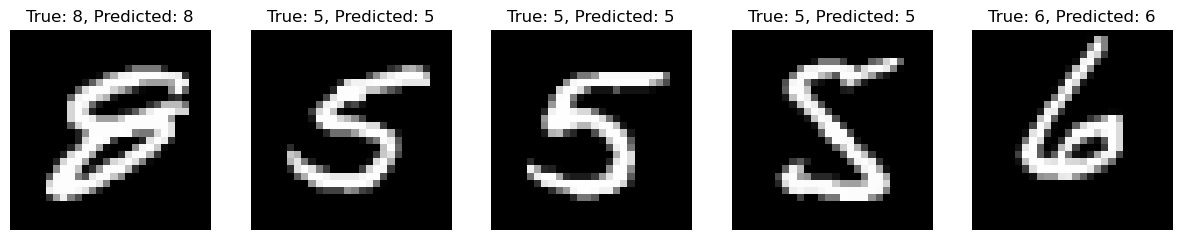

In [70]:
def predict(state, images):
    logits = state.apply_fn({'params': state.params}, images)
    return jnp.argmax(logits, axis=-1)

def visualize_predictions(state, dataset, n_display=5):
    # Get a batch of images and labels
    batch = next(iter(dataset.batch(10).as_numpy_iterator()))
    print(batch[0].shape)
    print(batch[1].shape)
    images, true_labels = batch
    images = images[-1]
    true_labels = true_labels[-1]
    
    # Make predictions
    predicted_labels = predict(state, images)
    
    # Plot the images with true and predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(n_display):
        plt.subplot(1, n_display, i+1)
        plt.imshow(images[i, ..., 0], cmap='gray')
        plt.title(f'True: {true_labels[i]}, Predicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.show()

visualize_predictions(state, dataset)
